## K-Means

### Data Import

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random as rd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [16]:
#reading each xlsx and changing columns to match to then concat
df2014 = pd.read_excel('data/ttc-streetcar-delay-data-2014.xlsx')
df2015 = pd.read_excel('data/ttc-streetcar-delay-data-2015.xlsx')
df2016 = pd.read_excel('data/ttc-streetcar-delay-data-2016.xlsx')
df2017 = pd.read_excel('data/ttc-streetcar-delay-data-2017.xlsx')
df2018 = pd.read_excel('data/ttc-streetcar-delay-data-2018.xlsx')
df2019 = pd.read_excel('data/ttc-streetcar-delay-data-2019.xlsx')
df2020 = pd.read_excel('data/ttc-streetcar-delay-data-2020_final.xlsx').rename(columns={'Delay':'Min Delay',
                                                                                  'Gap':'Min Gap'})
df2021 = pd.read_excel('data/ttc-streetcar-delay-data-jan-2021-to-august-2021.xlsx').rename(columns={'Bound':'Direction',
                                                                                               'Date':'Report Date',
                                                                                               'Line':'Route'})

df2014['Time'] = pd.to_datetime(df2014['Time'], format='%H:%M:%S').dt.time
df2015['Time'] = pd.to_datetime(df2015['Time'], format='%H:%M:%S').dt.time
df2016['Time'] = pd.to_datetime(df2016['Time'], format='%H:%M:%S').dt.time
df2017['Time'] = pd.to_datetime(df2017['Time'], format='%H:%M:%S').dt.time
df2018['Time'] = pd.to_datetime(df2018['Time'], format='%H:%M:%S').dt.time
df2019['Time'] = pd.to_datetime(df2019['Time'], format='%H:%M:%S').dt.time
df2020['Time'] = pd.to_datetime(df2020['Time'], format='%H:%M:%S').dt.time
df2021['Time'] = pd.to_datetime(df2021['Time'], format='%H:%M:%S').dt.time

frames = [df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021]
df = pd.concat(frames)

In [17]:
df = df.rename(columns={'Report Date':'Report_Date','Min Delay':'Min_Delay','Min Gap':'Min_Gap',
                       'Round Time':'Round_Time'})

### Removing NAs

In [18]:
#summing na values
df.isna().sum()

Report_Date      0
Route            2
Time             0
Day              0
Location        21
Incident         0
Min_Delay        3
Min_Gap          5
Direction       98
Vehicle        503
Round_Time       0
dtype: int64

In [19]:
#removing vehicle as a column
df = df.drop('Vehicle', axis=1)

In [20]:
#removing na values
df = df.dropna()
df

Report_Date Route      Time       Day                        Location  \
0     2014-01-02   505  06:31:00  Thursday         Dundas and Roncesvalles   
1     2014-01-02   504  12:43:00  Thursday                   King and Shaw   
2     2014-01-02   501  14:01:00  Thursday       Kingston road and Bingham   
3     2014-01-02   504  14:22:00  Thursday  King St. and Roncesvalles Ave.   
4     2014-01-02   504  16:42:00  Thursday               King and Bathurst   
...          ...   ...       ...       ...                             ...   
1012  2021-01-31   512  22:10:00    Sunday                     GUNN'S LOOP   
1013  2021-01-31   501  22:43:00    Sunday             QUEEN AND BROADVIEW   
1014  2021-01-31   504  00:15:00    Sunday                KING AND SPADINA   
1016  2021-01-31   501  00:46:00    Sunday                QUEEN AND CHURCH   
1017  2021-01-31   510  01:23:00    Sunday             SPADINA AND COLLEGE   

                 Incident  Min_Delay  Min_Gap Direction Round_Time  
0     Late Leaving Garage        4.0      8.0       E/B   06:30:00  
1      Utilized Off Route       20.0     22.0       E/B   12:30:00  
2                 Held By       13.0     19.0       W/B   14:00:00  
3           Investigation        7.0     11.0       W/B   14:30:00  
4      Utilized Off Route        3.0      6.0       E/B   16:30:00  
...                   ...        ...      ...       ...        ...  
1012           Mechanical        5.0     10.0         E   22:00:00  
1013   Emergency Services       11.0     21.0         W   22:30:00  
1014           Mechanical        3.0      8.0         W   00:30:00  
1016              Held By       13.0     23.0         W   01:00:00  
1017             Cleaning       12.0     24.0         N   01:30:00  

[8957 rows x 10 columns]

### Datetime continuous

In [21]:
from datetime import timedelta

time_in_minutes = []
time_in_hours = []

for time in df['Time']:
    delta = timedelta(hours=int(time.strftime('%H')), 
                      minutes=int(time.strftime('%M')), 
                      seconds=int(time.strftime('%S')))
    total_seconds = delta.total_seconds()
    time_in_minutes.append(total_seconds/60)
    time_in_hours.append(total_seconds/60/60)
    
df['Time_in_minutes'] = time_in_minutes
df['Time_in_hours'] = time_in_hours

### K-Means (delay and hours)

In [22]:
df_kmeans = df.drop(['Report_Date', 'Route', 'Time', 'Location', 'Incident', 'Min_Gap', 'Direction', 
                     'Round_Time', 'Time_in_minutes', 'Day'], axis=1)
df_kmeans

Min_Delay  Time_in_hours
0           4.0       6.516667
1          20.0      12.716667
2          13.0      14.016667
3           7.0      14.366667
4           3.0      16.700000
...         ...            ...
1012        5.0      22.166667
1013       11.0      22.716667
1014        3.0       0.250000
1016       13.0       0.766667
1017       12.0       1.383333

[8957 rows x 2 columns]

In [26]:
# Scale values from 0 to 1
df_scaled =  (df_kmeans - df_kmeans.min()) / (df_kmeans.max() - df_kmeans.min())
#it's important to scale the values otherwise you'll have some values that will take all the importance.

# Try various values of k
sil_scores = []
for k in range(10,20):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_scaled)
    label = clusterer.predict(df_scaled)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(df_scaled, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
df_kmeans.groupby(best_label).mean()

Min_Delay  Time_in_hours
0   117.860000      18.029000
1     7.162641       7.371014
2    10.690344      13.612560
3    10.967391      22.644263
4    14.704698       1.511298
5     8.047553       5.757409
6     8.246792      15.561533
7    11.353425      20.088265
8   142.095238       6.399206
9     9.053333      11.396733
10    9.308523      17.787035
11    8.860192       9.255301
12  455.111111      12.805556

In [81]:
df_scaled

Min_Delay  Time_in_hours
0      0.006667       0.271716
1      0.033333       0.530229
2      0.021667       0.584434
3      0.011667       0.599027
4      0.005000       0.696317
...         ...            ...
1012   0.008333       0.924253
1013   0.018333       0.947186
1014   0.005000       0.010424
1016   0.021667       0.031967
1017   0.020000       0.057679

[8957 rows x 2 columns]

In [27]:
df_kmeans.groupby(best_label).describe()

Min_Delay                                                              \
       count        mean        std    min     25%    50%     75%    max   
0       50.0  117.860000  43.160834   65.0   86.00  104.5  147.00  284.0   
1     1242.0    7.162641   7.310824    0.0    4.00    5.0    8.00   74.0   
2      901.0   10.690344  13.155759    0.0    5.00    6.0   10.00  142.0   
3      552.0   10.967391  11.460927    0.0    6.00    8.0   10.00  120.0   
4      447.0   14.704698  15.383806    0.0    7.00   10.0   15.00  127.0   
5     1451.0    8.047553   8.295479    0.0    4.00    6.0    9.00   75.0   
6     1013.0    8.246792   7.865489    0.0    4.00    6.0    9.00   62.0   
7      730.0   11.353425  11.692025    0.0    5.00    7.0   12.00   77.0   
8       42.0  142.095238  57.780413   80.0  101.75  129.0  169.25  292.0   
9      750.0    9.053333   9.537353    0.0    5.00    6.0    9.00   82.0   
10     833.0    9.308523   9.487321    0.0    5.00    6.0   10.00   63.0   
11     937.0    8.860192   9.862012    0.0    5.00    6.0    9.00   92.0   
12       9.0  455.111111  88.571221  313.0  418.00  458.0  502.00  600.0   

   Time_in_hours                                                        \
           count       mean       std        min        25%        50%   
0           50.0  18.029000  2.764354  12.766667  16.116667  18.191667   
1         1242.0   7.371014  0.492613   6.566667   6.950000   7.333333   
2          901.0  13.612560  0.587471  12.450000  13.100000  13.650000   
3          552.0  22.644263  0.764427  21.366667  21.979167  22.666667   
4          447.0   1.511298  0.930862   0.000000   0.716667   1.416667   
5         1451.0   5.757409  0.551420   3.633333   5.450000   5.850000   
6         1013.0  15.561533  0.569944  14.583333  15.083333  15.550000   
7          730.0  20.088265  0.712678  18.933333  19.454167  20.083333   
8           42.0   6.399206  2.376571   1.350000   5.395833   6.083333   
9          750.0  11.396733  0.627606  10.316667  10.850000  11.416667   
10         833.0  17.787035  0.650740  16.666667  17.216667  17.816667   
11         937.0   9.255301  0.562897   8.300000   8.766667   9.250000   
12           9.0  12.805556  4.982093   5.333333   9.683333  14.650000   

                          
          75%        max  
0   20.016667  23.150000  
1    7.800000   8.300000  
2   14.116667  14.600000  
3   23.283333  23.983333  
4    2.233333   3.566667  
5    6.166667   6.550000  
6   16.016667  16.666667  
7   20.750000  21.350000  
8    7.225000  11.950000  
9   11.966667  12.500000  
10  18.350000  18.933333  
11   9.700000  10.300000  
12  16.683333  18.800000

In [28]:
sil_scores

k  silhouette_score                                              label
0  10          0.487052  [1, 7, 0, 0, 4, 4, 4, 6, 5, 1, 1, 1, 1, 1, 1, ...
1  11          0.481008  [2, 5, 5, 5, 3, 6, 6, 0, 4, 2, 2, 2, 2, 2, 2, ...
2  12          0.488650  [2, 11, 8, 8, 3, 9, 9, 1, 7, 2, 2, 2, 2, 2, 2,...
3  13          0.492809  [5, 2, 2, 2, 10, 10, 10, 7, 4, 5, 5, 5, 5, 5, ...
4  14          0.476504  [10, 2, 2, 6, 1, 1, 13, 13, 5, 3, 3, 3, 3, 3, ...
5  15          0.466044  [1, 8, 11, 11, 9, 9, 5, 5, 4, 13, 13, 13, 13, ...
6  16          0.463874  [1, 10, 10, 10, 11, 11, 0, 0, 3, 9, 9, 9, 9, 9...
7  17          0.452672  [1, 14, 14, 0, 7, 12, 12, 2, 3, 15, 15, 15, 15...
8  18          0.448203  [10, 3, 13, 13, 0, 5, 17, 17, 4, 11, 11, 11, 1...
9  19          0.453050  [6, 8, 18, 18, 4, 4, 16, 16, 3, 14, 14, 14, 14...

For k = 3 The average silhouette_score is : 0.574524419984279
For k = 4 The average silhouette_score is : 0.5101078891631344
For k = 5 The average silhouette_score is : 0.5491503996752435
For k = 6 The average silhouette_score is : 0.5390024413694505
For k = 7 The average silhouette_score is : 0.5202578340682918
For k = 8 The average silhouette_score is : 0.5253382177519754
For k = 9 The average silhouette_score is : 0.5016477024793772
For k = 10 The average silhouette_score is : 0.48745905048598326
For k = 11 The average silhouette_score is : 0.4818356086970768
For k = 12 The average silhouette_score is : 0.48760722537157525
For k = 13 The average silhouette_score is : 0.4946864529718119
For k = 14 The average silhouette_score is : 0.4827116795027649
For k = 15 The average silhouette_score is : 0.47779589656691823
For k = 16 The average silhouette_score is : 0.46835025790212664
For k = 17 The average silhouette_score is : 0.45500106976641225
For k = 18 The average silhouette_score is 

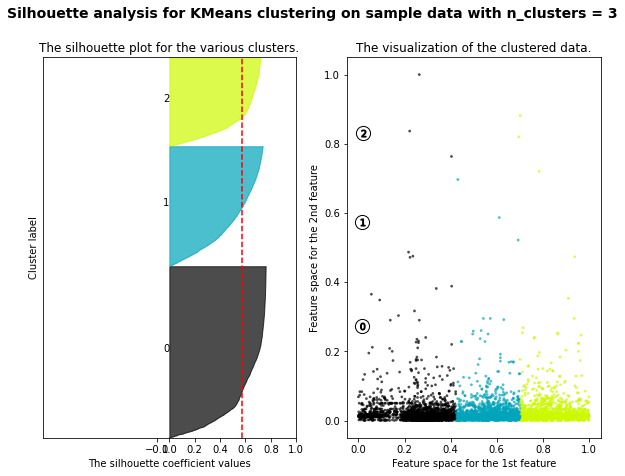

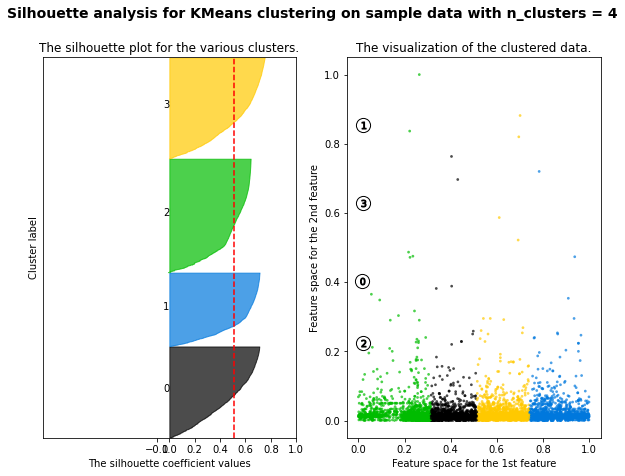

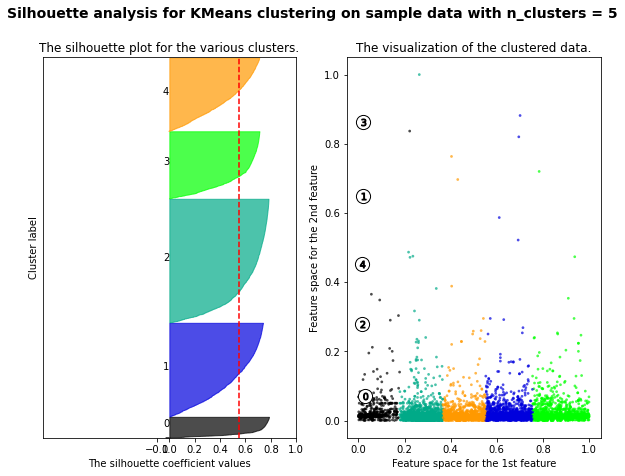

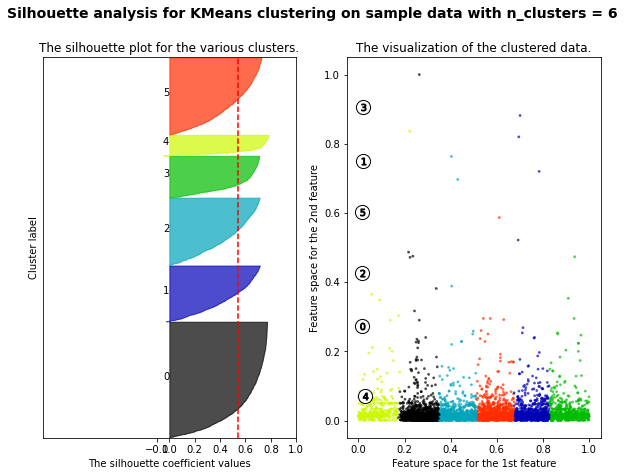

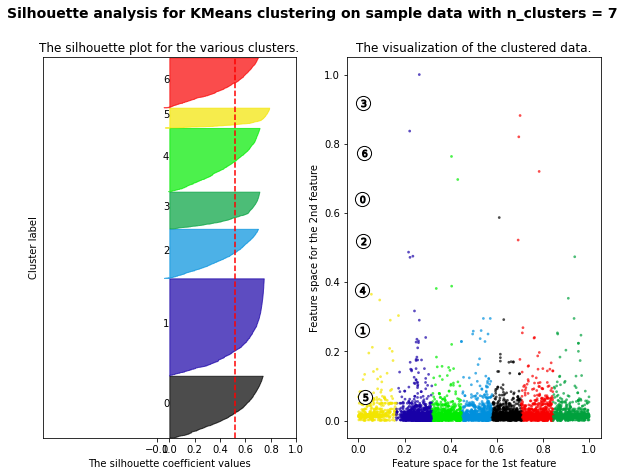

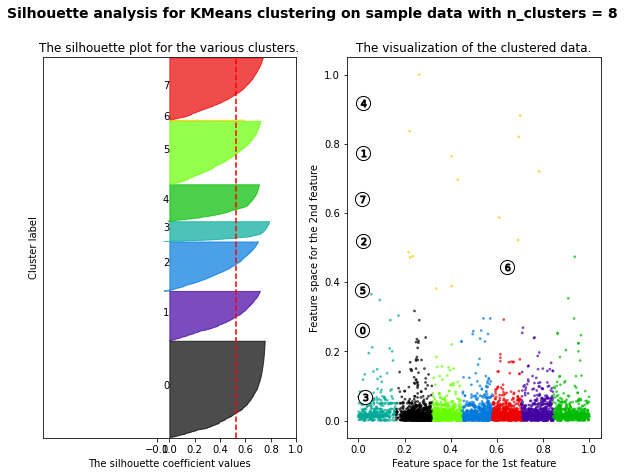

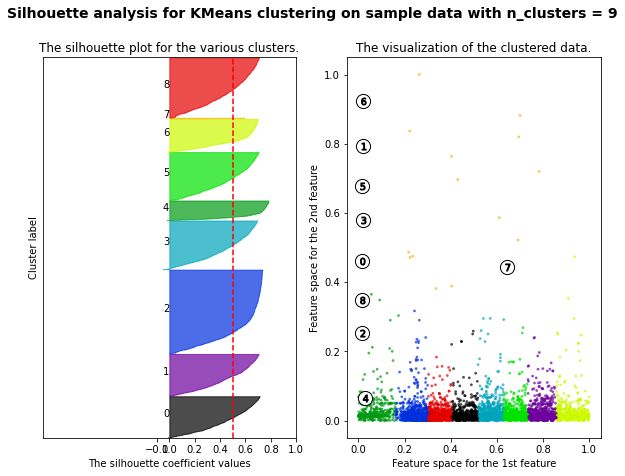

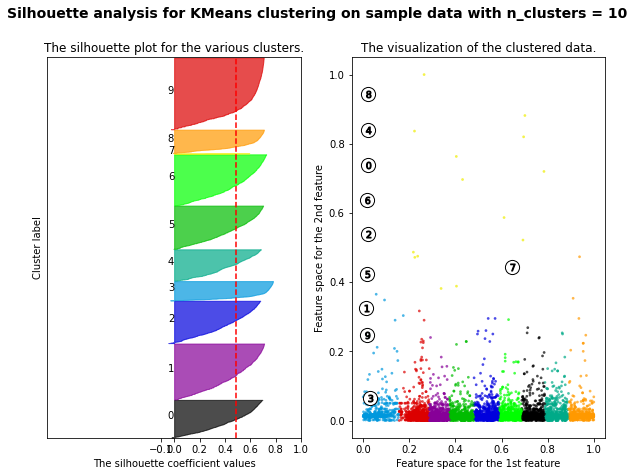

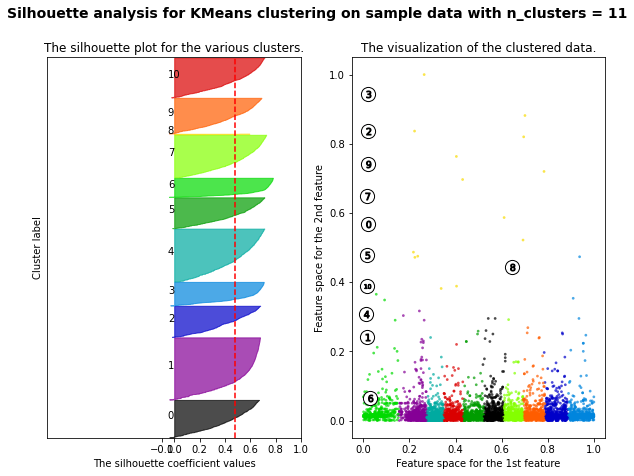

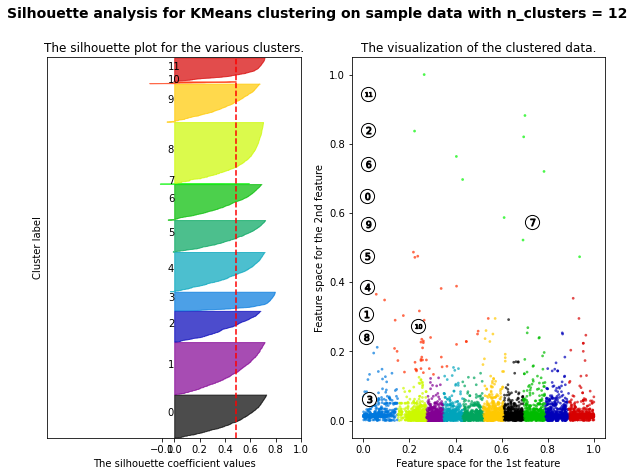

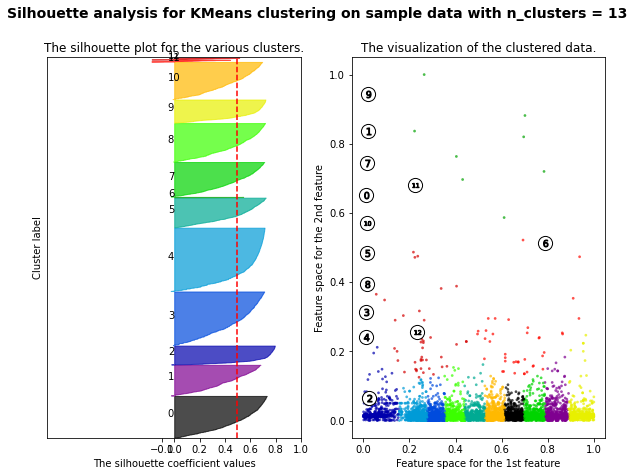

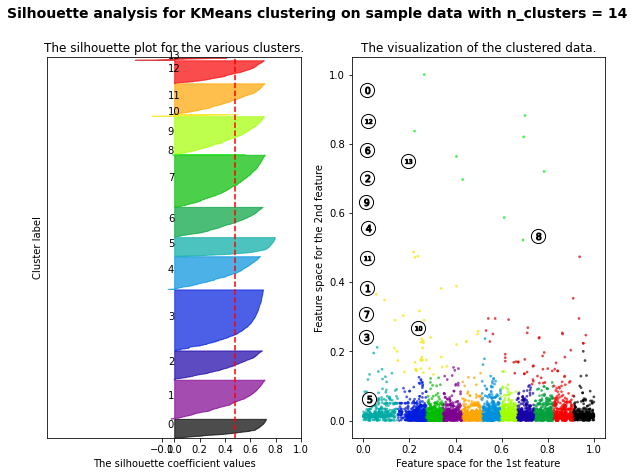

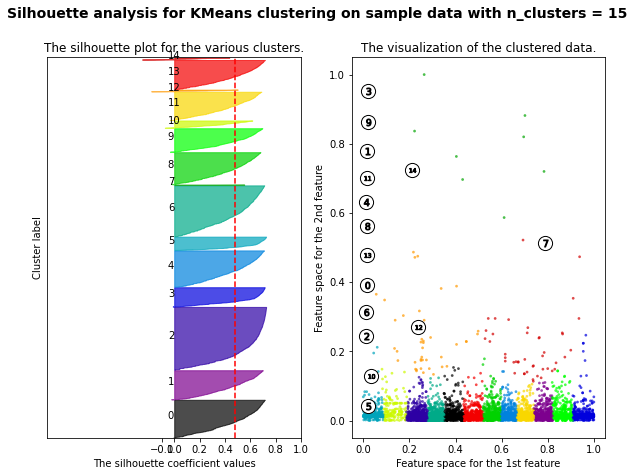

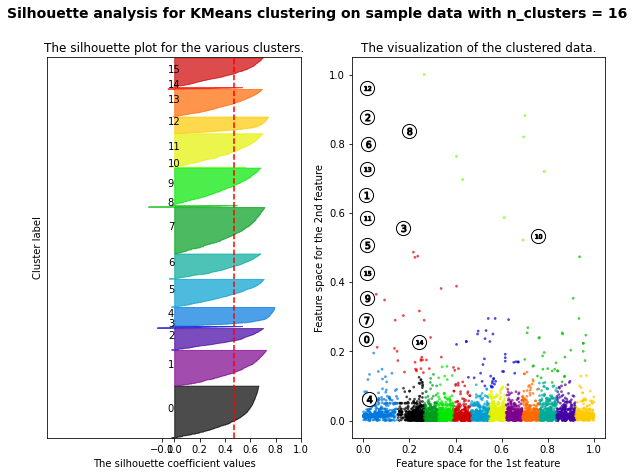

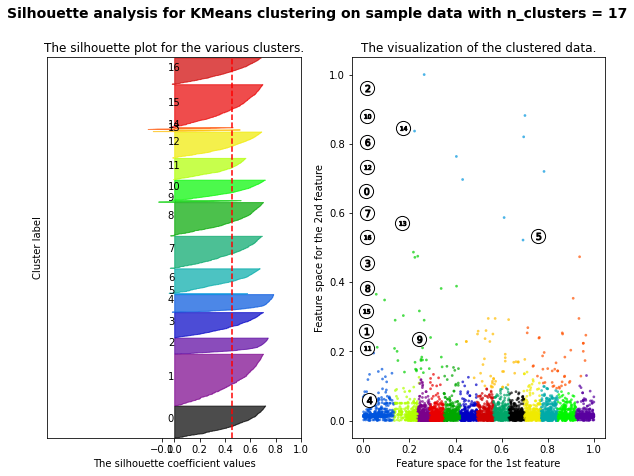

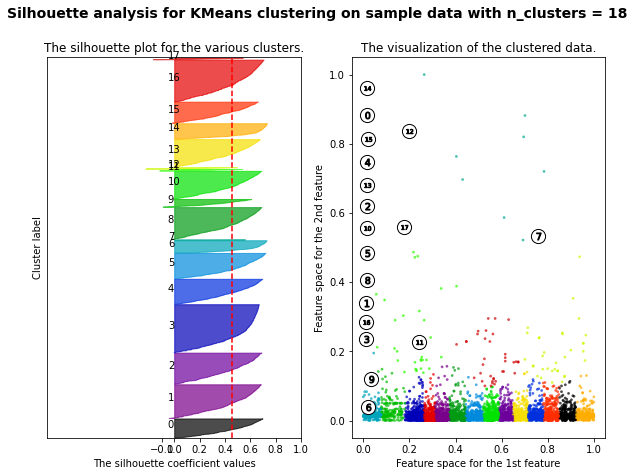

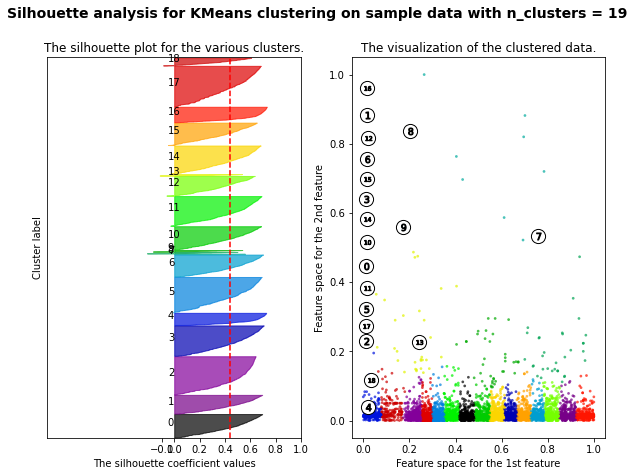

In [13]:
X, y = df_scaled['Time_in_hours'], df_scaled['Min_Delay']

for k in range(3,20):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(df_scaled)
    cluster_labels = clusterer.predict(df_scaled)
    
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        df_scaled['Time_in_hours'], df_scaled['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (day as dummy variable)

In [23]:
def clean_text(text):
    text = text.lower()
    text = text.replace(" ", "_")
    return text

df['Location'] = df['Location'].astype(str).apply(clean_text)
df['Incident'] = df['Incident'].astype(str).apply(clean_text)

In [133]:
cat_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Incident', 'Min_Gap'], axis=1)
cat_data

Day
0     Thursday
1     Thursday
2     Thursday
3     Thursday
4     Thursday
...        ...
1012    Sunday
1013    Sunday
1014    Sunday
1016    Sunday
1017    Sunday

[8957 rows x 1 columns]

In [146]:
#encoded df
kmeans_dummy = df

for cat in cat_data:
    dummies = pd.get_dummies(cat_data[cat])
    kmeans_dummy = pd.concat([kmeans_dummy, dummies], axis=1)
    kmeans_dummy = kmeans_dummy.drop(cat, axis=1)

kmeans_dummy = kmeans_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Location', 'Incident', 'Time_in_minutes',
                     'Direction', 'Min_Gap'], axis=1)
kmeans_dummy

Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0           4.0       6.516667       0       0         0       0         1   
1          20.0      12.716667       0       0         0       0         1   
2          13.0      14.016667       0       0         0       0         1   
3           7.0      14.366667       0       0         0       0         1   
4           3.0      16.700000       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012        5.0      22.166667       0       0         0       1         0   
1013       11.0      22.716667       0       0         0       1         0   
1014        3.0       0.250000       0       0         0       1         0   
1016       13.0       0.766667       0       0         0       1         0   
1017       12.0       1.383333       0       0         0       1         0   

      Tuesday  Wednesday  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
...       ...        ...  
1012        0          0  
1013        0          0  
1014        0          0  
1016        0          0  
1017        0          0  

[8957 rows x 9 columns]

In [152]:
kmeans_dummy['Min_Delay'] = (kmeans_dummy['Min_Delay'] - kmeans_dummy['Min_Delay'].min()) / (kmeans_dummy['Min_Delay'].max() - kmeans_dummy['Min_Delay'].min())
kmeans_dummy['Time_in_hours'] = (kmeans_dummy['Time_in_hours'] - kmeans_dummy['Time_in_hours'].min()) / (kmeans_dummy['Time_in_hours'].max() - kmeans_dummy['Time_in_hours'].min())


In [153]:
kmeans_dummy

Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0      0.006667       0.271716       0       0         0       0         1   
1      0.033333       0.530229       0       0         0       0         1   
2      0.021667       0.584434       0       0         0       0         1   
3      0.011667       0.599027       0       0         0       0         1   
4      0.005000       0.696317       0       0         0       0         1   
...         ...            ...     ...     ...       ...     ...       ...   
1012   0.008333       0.924253       0       0         0       1         0   
1013   0.018333       0.947186       0       0         0       1         0   
1014   0.005000       0.010424       0       0         0       1         0   
1016   0.021667       0.031967       0       0         0       1         0   
1017   0.020000       0.057679       0       0         0       1         0   

      Tuesday  Wednesday  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
...       ...        ...  
1012        0          0  
1013        0          0  
1014        0          0  
1016        0          0  
1017        0          0  

[8957 rows x 9 columns]

In [158]:
# Try various values of k
sil_scores = []
for k in range(5,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    label = clusterer.predict(kmeans_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(kmeans_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
kmeans_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  Friday  Monday  Saturday  Sunday  Thursday  \
0   0.021980       0.499448     0.0     0.0       0.0     1.0       0.0   
1   0.017233       0.489691     1.0     0.0       0.0     0.0       0.0   
2   0.019396       0.491290     0.0     0.0       0.0     0.0       1.0   
3   0.017697       0.470975     0.0     0.0       0.0     0.0       0.0   
4   0.018102       0.490871     0.0     0.0       0.0     0.0       0.0   
5   0.015840       0.501836     0.0     1.0       0.0     0.0       0.0   
6   0.019421       0.548532     0.0     0.0       1.0     0.0       0.0   

   Tuesday  Wednesday  
0      0.0        0.0  
1      0.0        0.0  
2      0.0        0.0  
3      1.0        0.0  
4      0.0        1.0  
5      0.0        0.0  
6      0.0        0.0

For k = 5 The average silhouette_score is : 0.6147274268553108
For k = 6 The average silhouette_score is : 0.7208251823890025
For k = 7 The average silhouette_score is : 0.8080954823444463
For k = 8 The average silhouette_score is : 0.7808876562301295
For k = 9 The average silhouette_score is : 0.7581956692272115
For k = 10 The average silhouette_score is : 0.733008123017515
For k = 11 The average silhouette_score is : 0.70788476192619
For k = 12 The average silhouette_score is : 0.6853357599398233
For k = 13 The average silhouette_score is : 0.6555376820564199
For k = 14 The average silhouette_score is : 0.6353916548627618


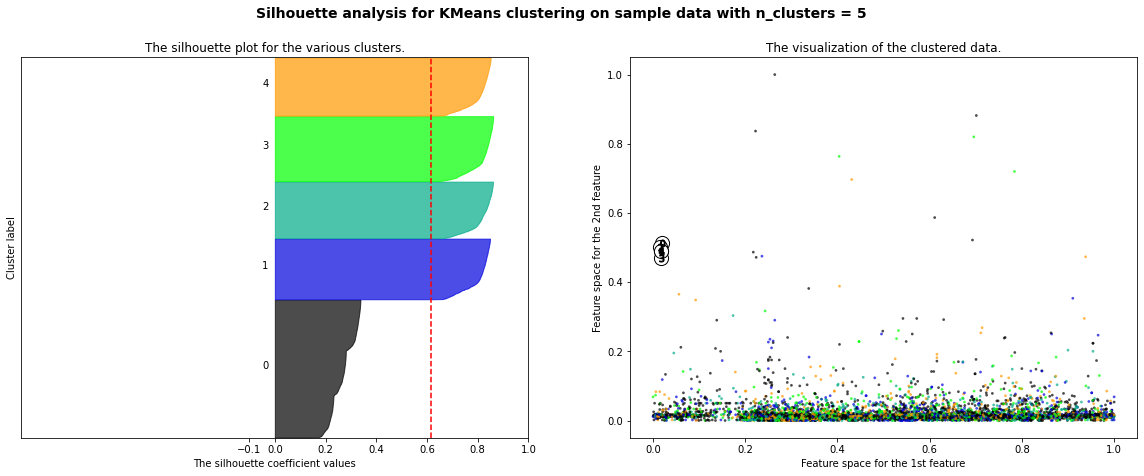

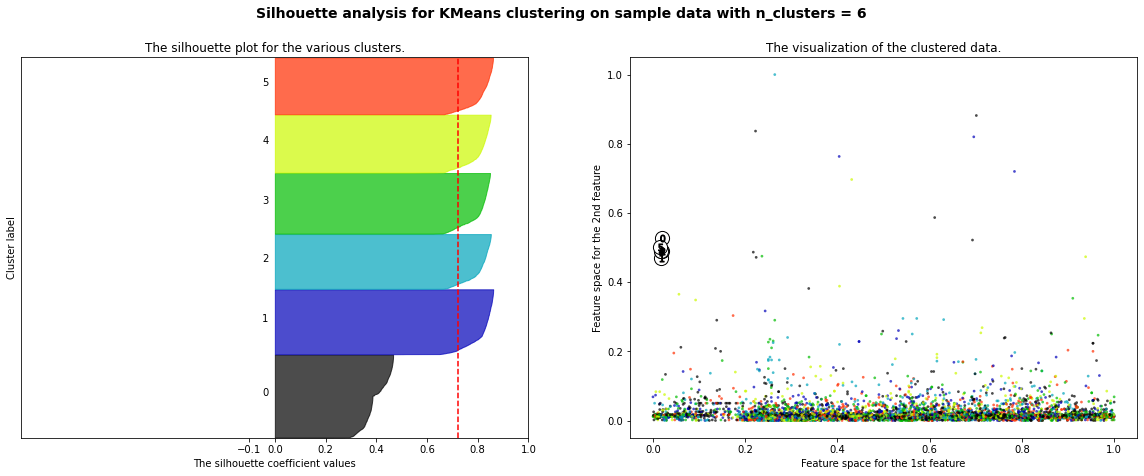

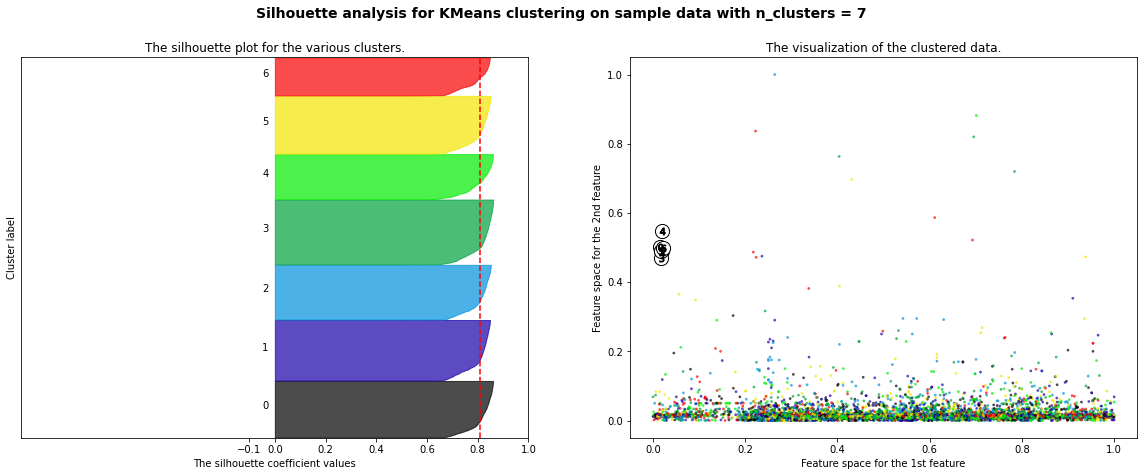

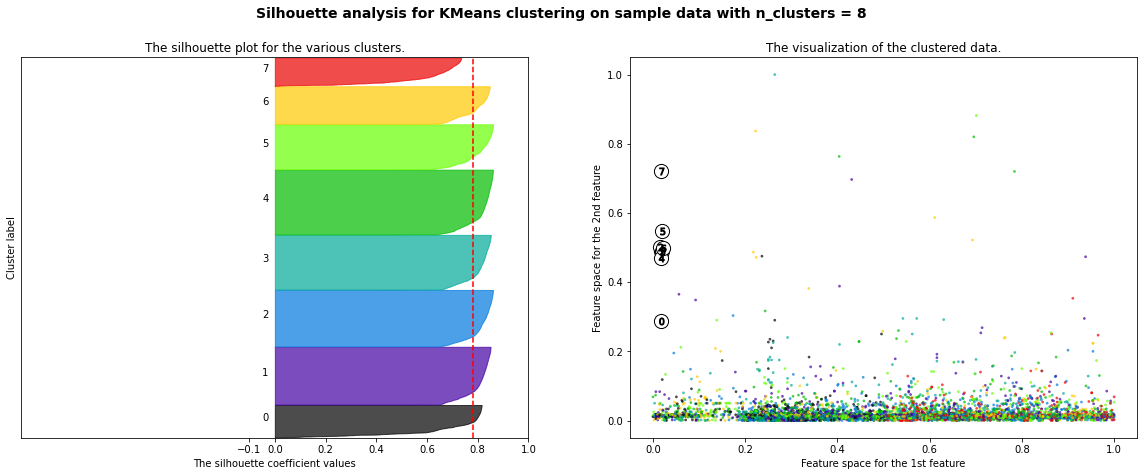

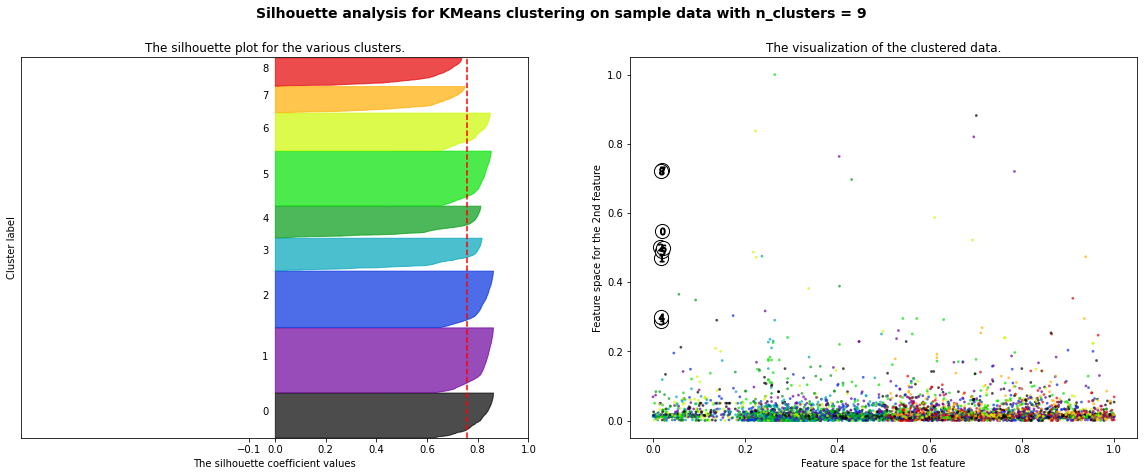

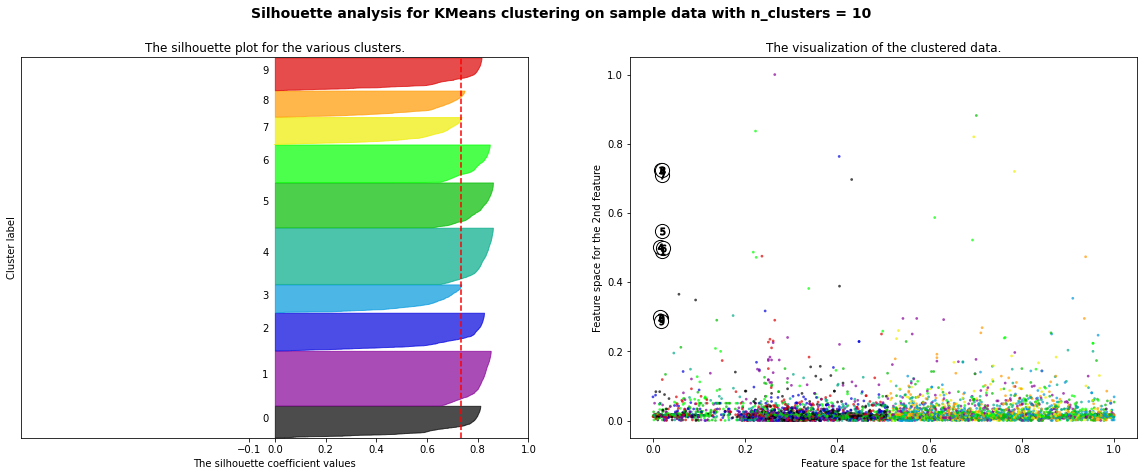

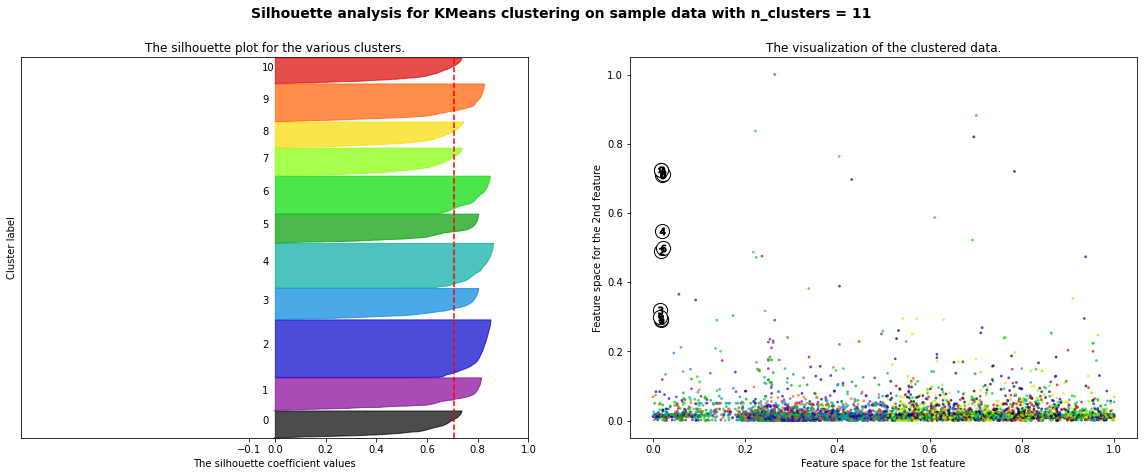

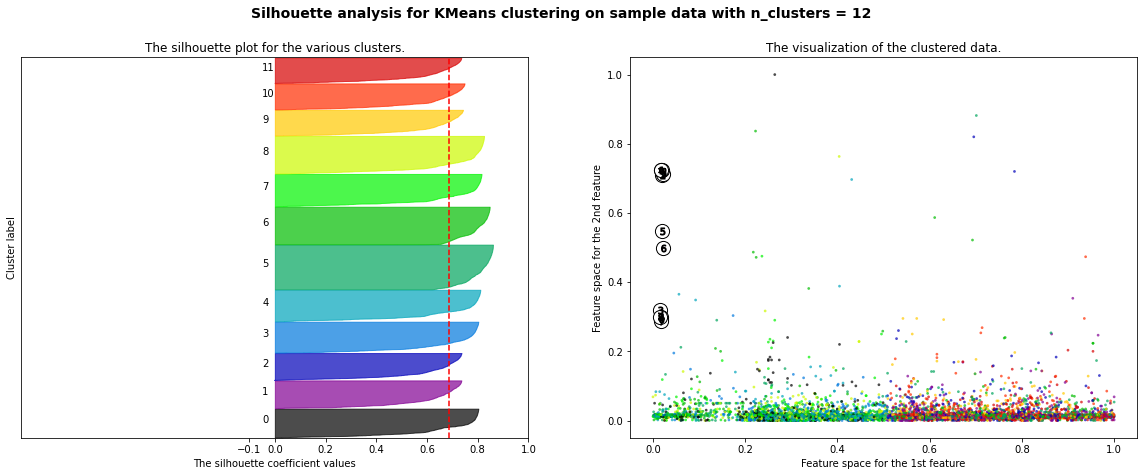

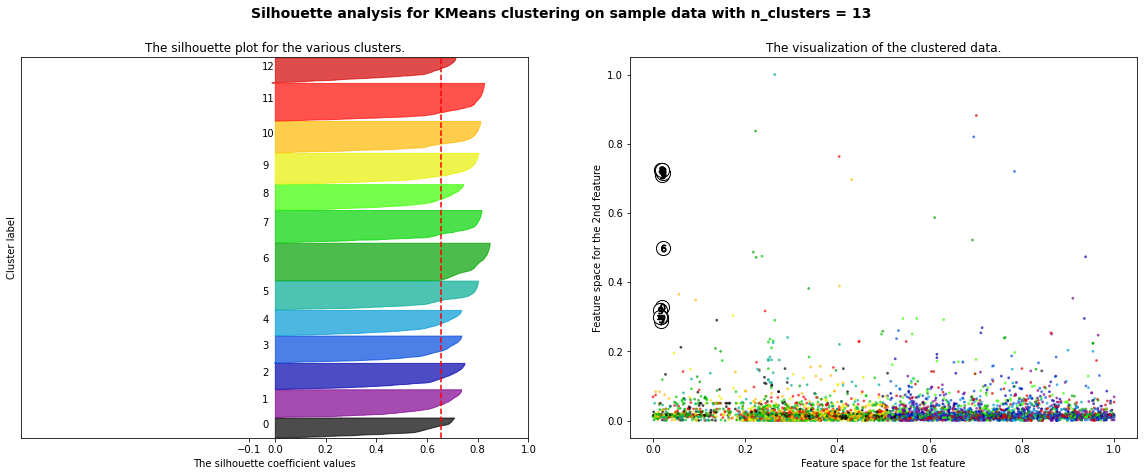

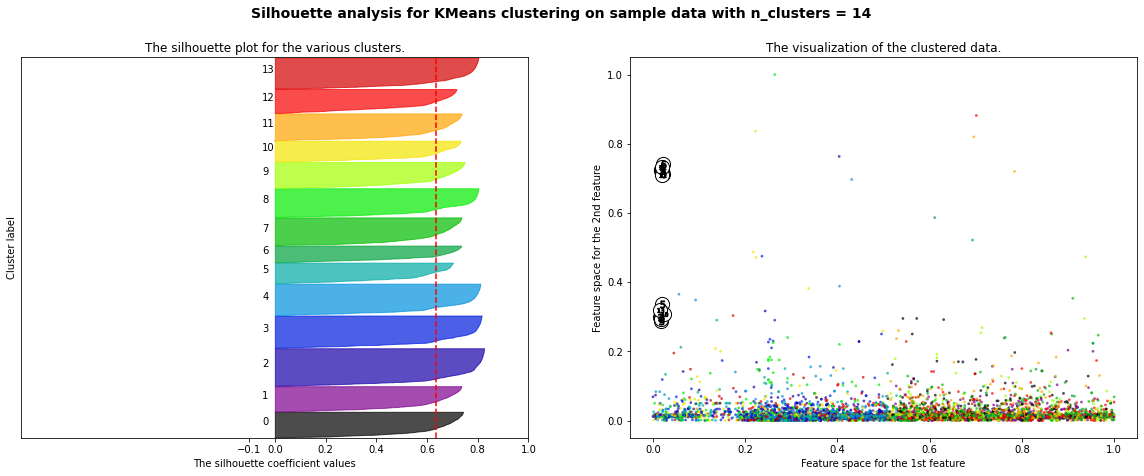

In [172]:
X, y = kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay']

for k in range(5,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(kmeans_dummy)
    cluster_labels = clusterer.predict(kmeans_dummy)
    
    silhouette_avg = silhouette_score(kmeans_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(kmeans_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        kmeans_dummy['Time_in_hours'], kmeans_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (day as dummy variable)

In [162]:
location_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Incident', 'Min_Gap'], axis=1)
location_data

Location
0            dundas_and_roncesvalles
1                      king_and_shaw
2          kingston_road_and_bingham
3     king_st._and_roncesvalles_ave.
4                  king_and_bathurst
...                              ...
1012                     gunn's_loop
1013             queen_and_broadview
1014                king_and_spadina
1016                queen_and_church
1017             spadina_and_college

[8957 rows x 1 columns]

In [166]:
#encoded df
location_dummy = df

for i in location_data:
    dummies = pd.get_dummies(location_data[i])
    location_dummy = pd.concat([location_dummy, dummies], axis=1)
    location_dummy = location_dummy.drop(cat, axis=1)

location_dummy = location_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Incident', 
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

location_dummy['Min_Delay'] = (location_dummy['Min_Delay'] - location_dummy['Min_Delay'].min()) / (location_dummy['Min_Delay'].max() - location_dummy['Min_Delay'].min())
location_dummy['Time_in_hours'] = (location_dummy['Time_in_hours'] - location_dummy['Time_in_hours'].min()) / (location_dummy['Time_in_hours'].max() - location_dummy['Time_in_hours'].min())

location_dummy


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
0      0.006667       0.271716                  0                           0   
1      0.033333       0.530229                  0                           0   
2      0.021667       0.584434                  0                           0   
3      0.011667       0.599027                  0                           0   
4      0.005000       0.696317                  0                           0   
...         ...            ...                ...                         ...   
1012   0.008333       0.924253                  0                           0   
1013   0.018333       0.947186                  0                           0   
1014   0.005000       0.010424                  0                           0   
1016   0.021667       0.031967                  0                           0   
1017   0.020000       0.057679                  0                           0   

      28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
0                             0                 0                          0   
1                             0                 0                          0   
2                             0                 0                          0   
3                             0                 0                          0   
4                             0                 0                          0   
...                         ...               ...                        ...   
1012                          0                 0                          0   
1013                          0                 0                          0   
1014                          0                 0                          0   
1016                          0                 0                          0   
1017                          0                 0                          0   

      40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
0                    0            0                0  ...            0   
1                    0            0                0  ...            0   
2                    0            0                0  ...            0   
3                    0            0                0  ...            0   
4                    0            0                0  ...            0   
...                ...          ...              ...  ...          ...   
1012                 0            0                0  ...            0   
1013                 0            0                0  ...            0   
1014                 0            0                0  ...            0   
1016                 0            0                0  ...            0   
1017                 0            0                0  ...            0   

      york_/_adelaide  york_/_king  york_/_queen  york_and_king  \
0                   0            0             0              0   
1                   0            0             0              0   
2                   0            0             0              0   
3                   0            0             0              0   
4                   0            0             0              0   
...               ...          ...           ...            ...   
1012                0            0             0              0   
1013                0            0             0              0   
1014                0            0             0              0   
1016                0            0             0              0   
1017                0            0             0              0   

      york_and_queen  york_and_queens_quay  york_and_queensquay  \
0                  0                     0                    0   
1                  0                     0                    0   
2                  0                     0                    0   
3                  0                     0                    0   
4                  0                     0 

In [168]:
# Try various values of k
sil_scores = []
for k in range(10,20):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    label = clusterer.predict(location_dummy)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(location_dummy, label), 'label':label})
    # applying k means and saving the values to a list

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label'] #k value (idxmax()) that maximizes the silhouette score
best_label

# Present some summary statistics for each clusters
location_dummy.groupby(best_label).mean()


Min_Delay  Time_in_hours  1st_and_lakeshore  24_th_street_and_lakeshore  \
0    0.015162       0.408319           0.000000                    0.000000   
1    0.020319       0.624924           0.000000                    0.000501   
2    0.011652       0.584512           0.000000                    0.000000   
3    0.009811       0.245873           0.000000                    0.000000   
4    0.013690       0.543624           0.000000                    0.000000   
5    0.021946       0.854624           0.000000                    0.000000   
6    0.011783       0.547483           0.000000                    0.000000   
7    0.009559       0.473324           0.000000                    0.000000   
8    0.017113       0.383524           0.000507                    0.000000   
9    0.009663       0.446611           0.000000                    0.000000   
10   0.014886       0.524875           0.000000                    0.000000   
11   0.012277       0.518044           0.000000                    0.000000   
12   0.010254       0.338238           0.000000                    0.000000   
13   0.026320       0.293738           0.000000                    0.000000   
14   0.010738       0.378512           0.000000                    0.000000   
15   0.009502       0.391157           0.000000                    0.000000   
16   0.020712       0.196906           0.000000                    0.000000   
17   0.009673       0.325978           0.000000                    0.000000   

    28th_street_and_lakeshore  37th_/_lakeshore  37th_street_and_lakeshore  \
0                    0.000000          0.000000                   0.000000   
1                    0.000501          0.000000                   0.000501   
2                    0.000000          0.000000                   0.000000   
3                    0.000000          0.000000                   0.000000   
4                    0.000000          0.000000                   0.000000   
5                    0.000000          0.000000                   0.000000   
6                    0.000000          0.000000                   0.000000   
7                    0.000000          0.000000                   0.000000   
8                    0.000000          0.000507                   0.000000   
9                    0.000000          0.000000                   0.000000   
10                   0.000000          0.000000                   0.000000   
11                   0.000000          0.000000                   0.000000   
12                   0.000000          0.000000                   0.000000   
13                   0.000000          0.000000                   0.000000   
14                   0.000000          0.000000                   0.000000   
15                   0.000000          0.000000                   0.000000   
16                   0.000000          0.000000                   0.000000   
17                   0.000000          0.000000                   0.000000   

    40th_/_lakeshore  506_carlton  5th_/_lakeshore  ...  york/_queen  \
0           0.000000     0.000000         0.000000  ...     0.000000   
1           0.000000     0.002004         0.000000  ...     0.000501   
2           0.000000     0.000000         0.000000  ...     0.000000   
3           0.000000     0.000000         0.000000  ...     0.000000   
4           0.000000     0.000000         0.000000  ...     0.000000   
5           0.000000     0.001969         0.000000  ...     0.000000   
6           0.000000     0.000000         0.000000  ...     0.000000   
7           0.000000     0.000000         0.000000  ...     0.000000   
8           0.000507     0.000000         0.000507  ...     0.000000   
9           0.000000     0.000000         0.000000  ...     0.000000   
10          0.000000     0.000000         0.000000  ...     0.000000   
11          0.000000     0.000000         0.000000  ...     0.000000   
12          0.000000     0.000000         0.000000  ...     0.000000   
13         

For k = 5 The average silhouette_score is : 0.05825223518637723
For k = 6 The average silhouette_score is : 0.06777570699639737
For k = 7 The average silhouette_score is : 0.08609664627205824
For k = 8 The average silhouette_score is : 0.10069269446651945
For k = 9 The average silhouette_score is : 0.11356048444088244


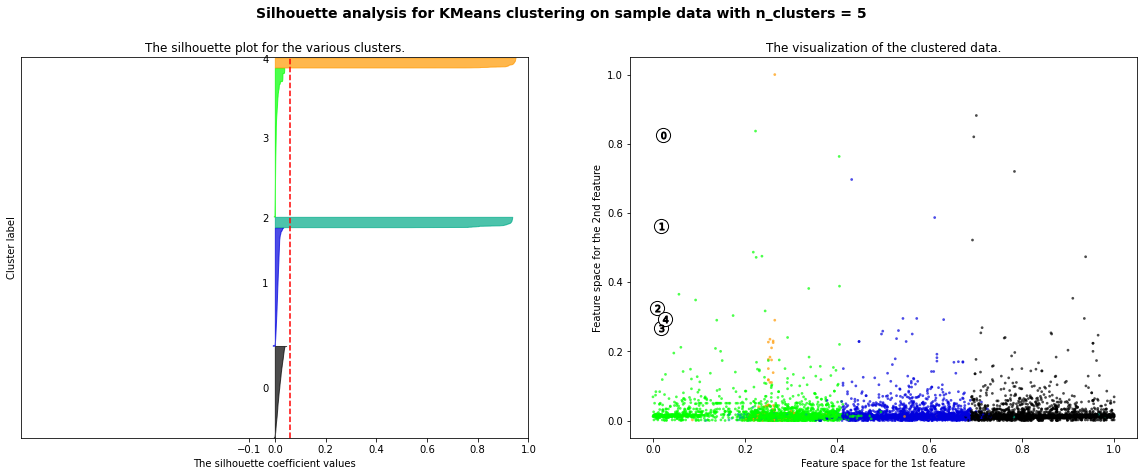

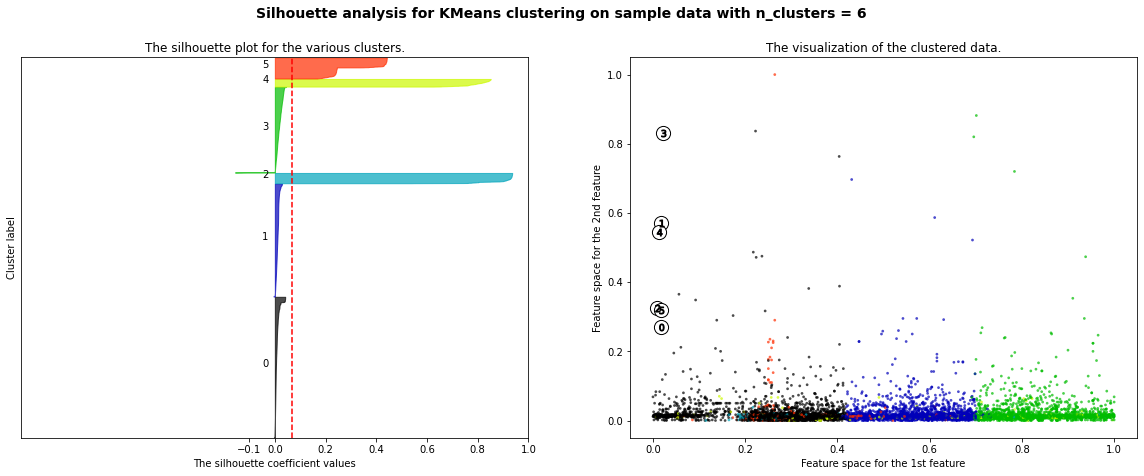

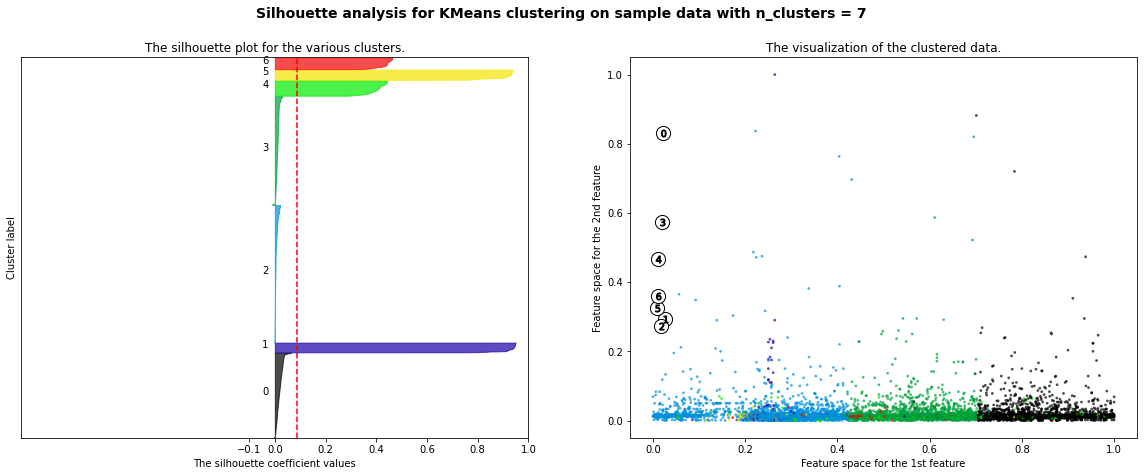

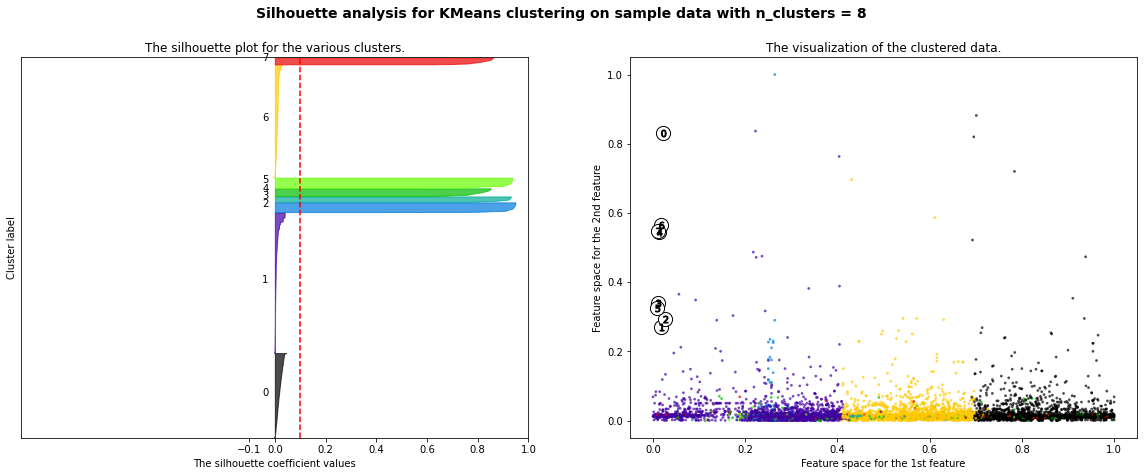

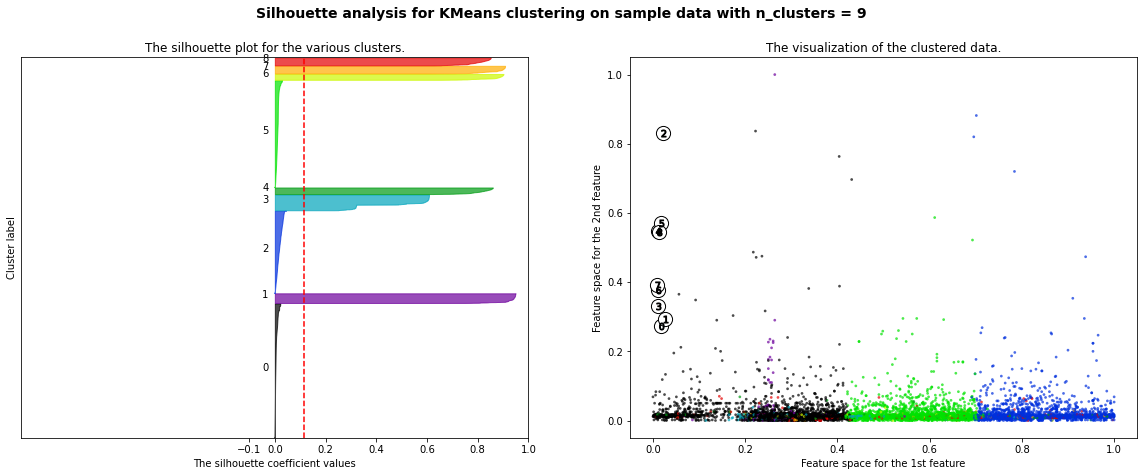

In [170]:
X, y = location_dummy['Time_in_hours'], location_dummy['Min_Delay']

for k in range(5,10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(location_dummy)
    cluster_labels = clusterer.predict(location_dummy)
    
    silhouette_avg = silhouette_score(location_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(location_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        location_dummy['Time_in_hours'], location_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    

### K-Means (incident as dummy variables)

In [174]:
incident_data = df.drop(['Time_in_minutes', 'Report_Date', 'Min_Delay', 'Direction', 'Day',
                   'Round_Time', 'Time_in_hours', 'Route', 'Time', 'Location', 'Min_Gap'], axis=1)
incident_data

Incident
0     late_leaving_garage
1      utilized_off_route
2                 held_by
3           investigation
4      utilized_off_route
...                   ...
1012           mechanical
1013   emergency_services
1014           mechanical
1016              held_by
1017             cleaning

[8957 rows x 1 columns]

In [177]:
#encoded df
incident_dummy = df

for i in incident_data:
    dummies = pd.get_dummies(incident_data[i])
    incident_dummy = pd.concat([incident_dummy, dummies], axis=1)
    incident_dummy = incident_dummy.drop(i, axis=1)

incident_dummy = incident_dummy.drop(['Report_Date', 'Round_Time', 'Time', 'Route', 'Day',
                                      'Time_in_minutes','Direction', 'Min_Gap', 'Location'], axis=1)

incident_dummy['Min_Delay'] = (location_dummy['Min_Delay'] - location_dummy['Min_Delay'].min()) / (location_dummy['Min_Delay'].max() - location_dummy['Min_Delay'].min())
incident_dummy['Time_in_hours'] = (location_dummy['Time_in_hours'] - location_dummy['Time_in_hours'].min()) / (location_dummy['Time_in_hours'].max() - location_dummy['Time_in_hours'].min())

incident_dummy


Min_Delay  Time_in_hours  cleaning  collision_-_ttc_involved  diversion  \
0      0.006667       0.271716         0                         0          0   
1      0.033333       0.530229         0                         0          0   
2      0.021667       0.584434         0                         0          0   
3      0.011667       0.599027         0                         0          0   
4      0.005000       0.696317         0                         0          0   
...         ...            ...       ...                       ...        ...   
1012   0.008333       0.924253         0                         0          0   
1013   0.018333       0.947186         0                         0          0   
1014   0.005000       0.010424         0                         0          0   
1016   0.021667       0.031967         0                         0          0   
1017   0.020000       0.057679         1                         0          0   

      emergency_services  general_delay  held_by  investigation  late  \
0                      0              0        0              0     0   
1                      0              0        0              0     0   
2                      0              0        1              0     0   
3                      0              0        0              1     0   
4                      0              0        0              0     0   
...                  ...            ...      ...            ...   ...   
1012                   0              0        0              0     0   
1013                   1              0        0              0     0   
1014                   0              0        0              0     0   
1016                   0              0        1              0     0   
1017                   0              0        0              0     0   

      late_leaving_garage  mechanical  operations  overhead  \
0                       1           0           0         0   
1                       0           0           0         0   
2                       0           0           0         0   
3                       0           0           0         0   
4                       0           0           0         0   
...                   ...         ...         ...       ...   
1012                    0           1           0         0   
1013                    0           0           0         0   
1014                    0           1           0         0   
1016                    0           0           0         0   
1017                    0           0           0         0   

      overhead_-_pantograph  rail/switches  security  utilized_off_route  
0                         0              0         0                   0  
1                         0              0         0                   1  
2                         0              0         0                   0  
3                         0              0         0                   0  
4                         0              0         0                   1  
...                     ...            ...       ...                 ...  
1012                      0              0         0                   0  
1013                      0              0         0                   0  
1014                      0              0         0                   0  
1016                      0              0         0                   0  
1017                      0              0         0                   0  

[8957 rows x 18 columns]

For k = 2 The average silhouette_score is : 0.4735604991301108
For k = 3 The average silhouette_score is : 0.5604421871230411
For k = 4 The average silhouette_score is : 0.6365556950834428
For k = 5 The average silhouette_score is : 0.6977998860054282
For k = 6 The average silhouette_score is : 0.728957929009116
For k = 7 The average silhouette_score is : 0.7545898669358185
For k = 8 The average silhouette_score is : 0.7767610901185578
For k = 9 The average silhouette_score is : 0.7931321635091473
For k = 10 The average silhouette_score is : 0.7067221638924212
For k = 11 The average silhouette_score is : 0.7185333545840009
For k = 12 The average silhouette_score is : 0.7237160208033221
For k = 13 The average silhouette_score is : 0.7280548696061071
For k = 14 The average silhouette_score is : 0.703909184014841


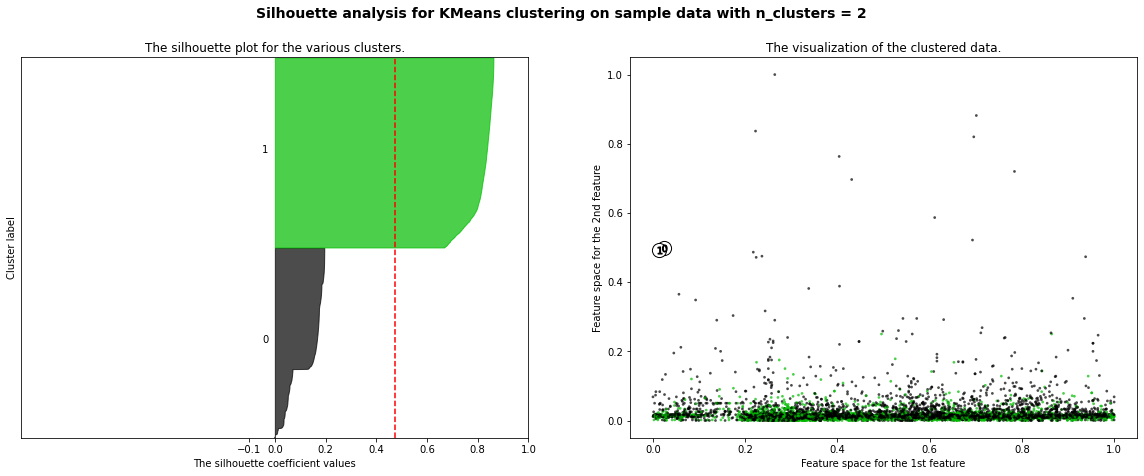

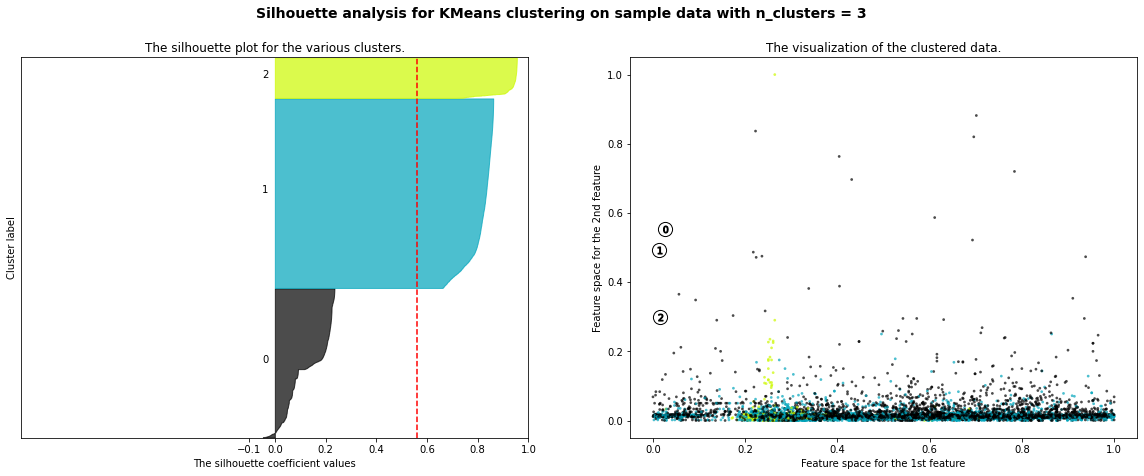

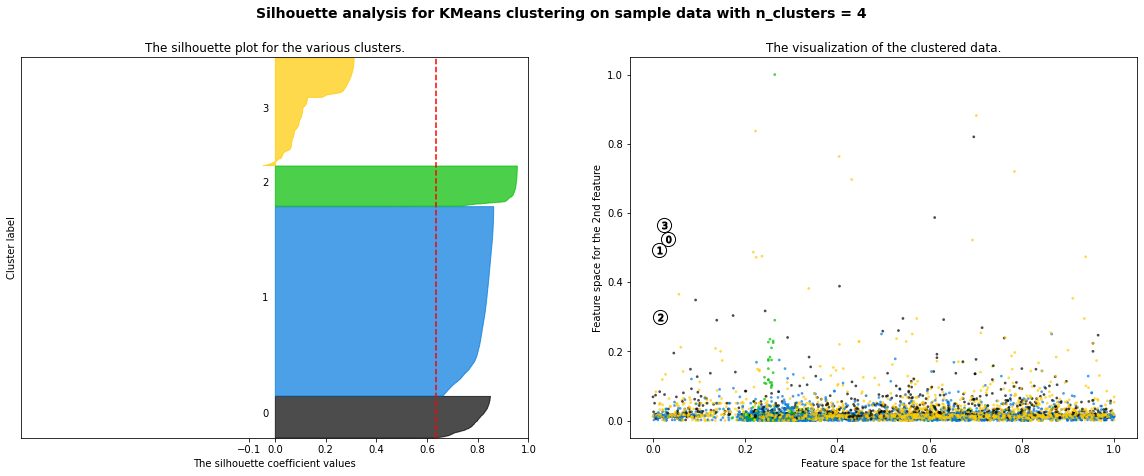

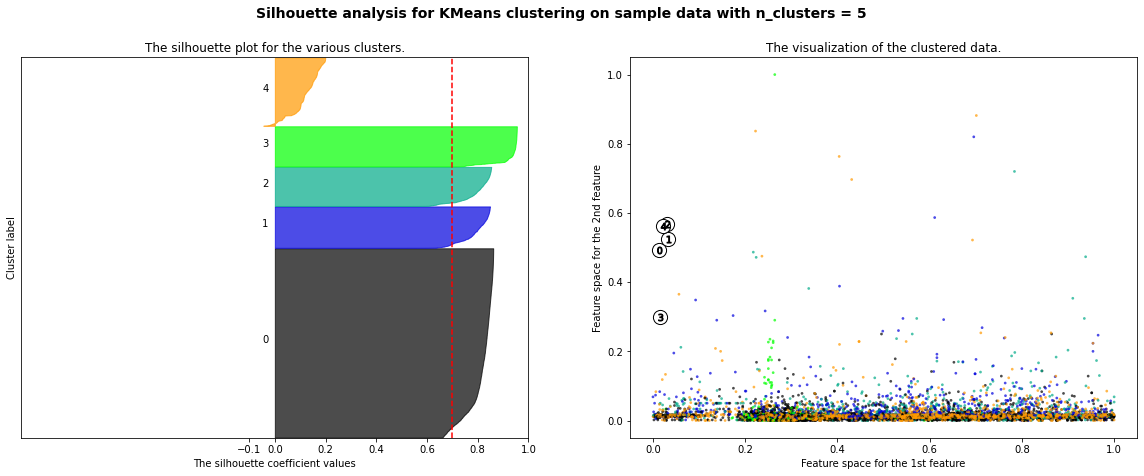

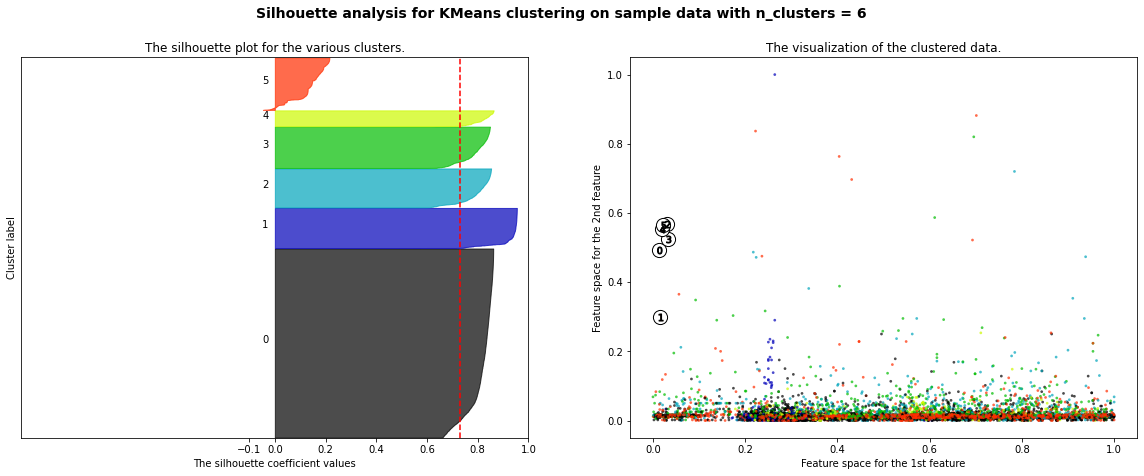

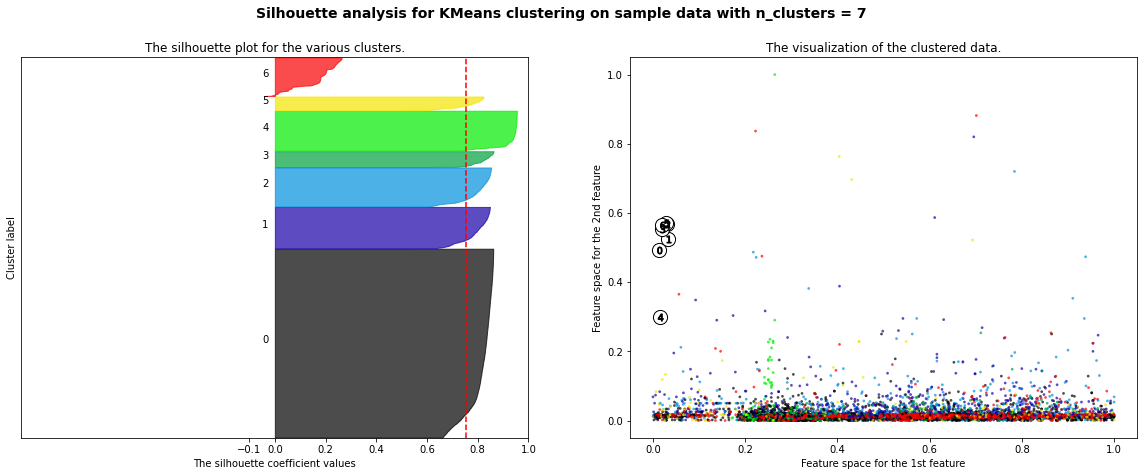

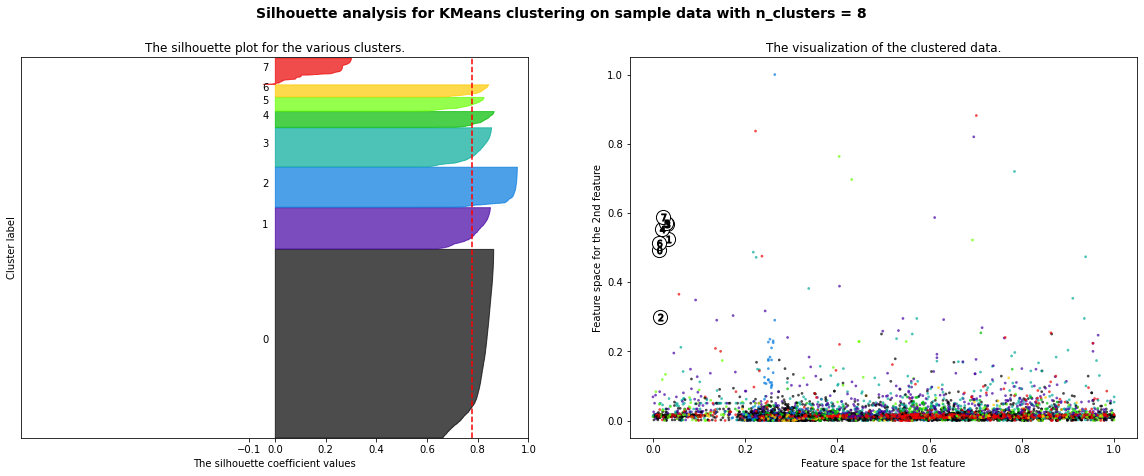

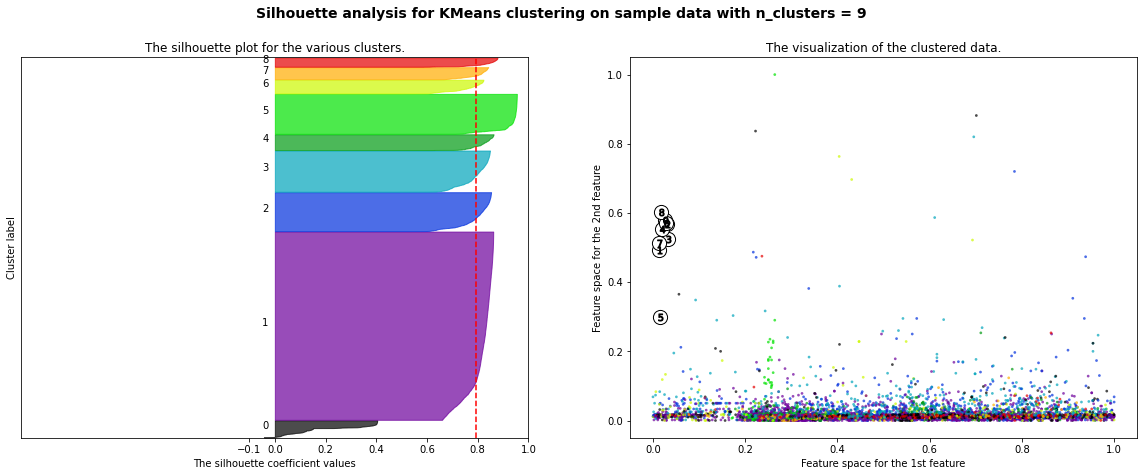

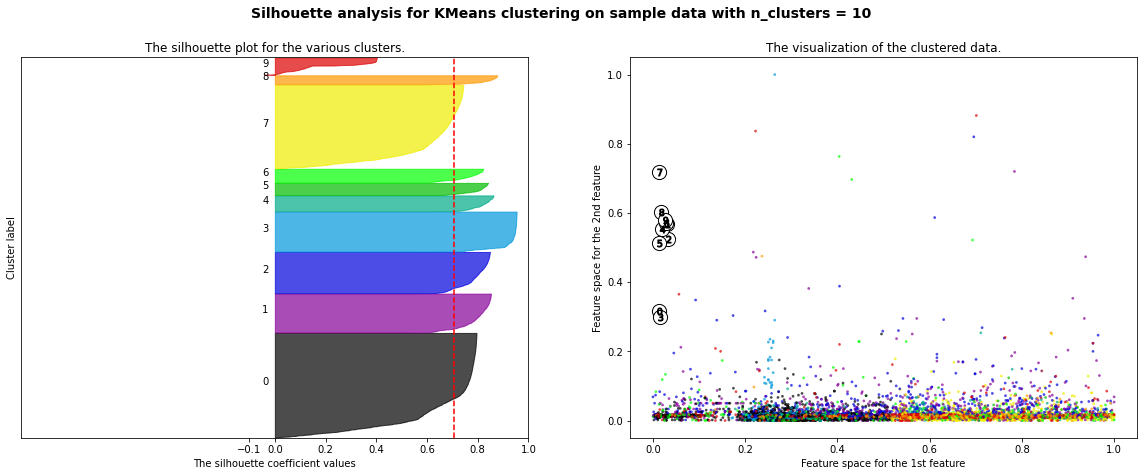

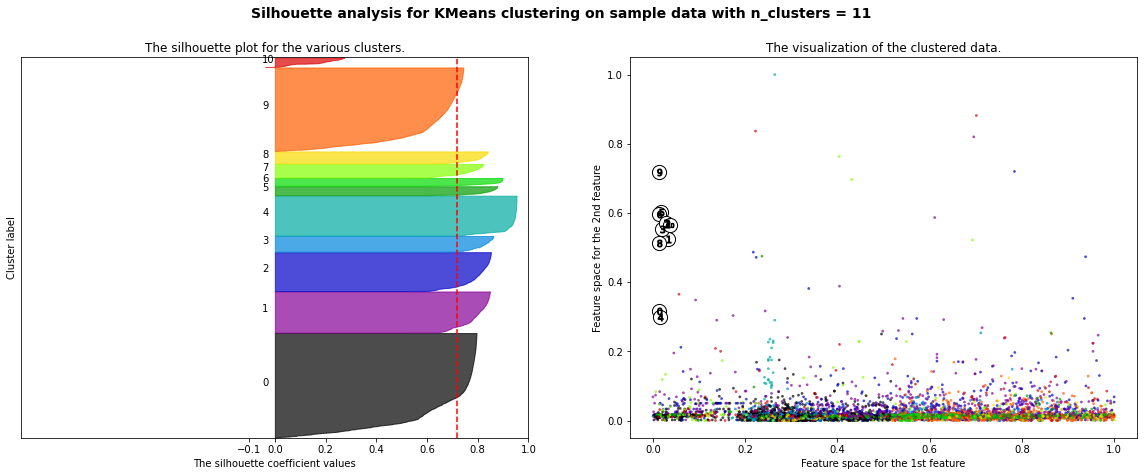

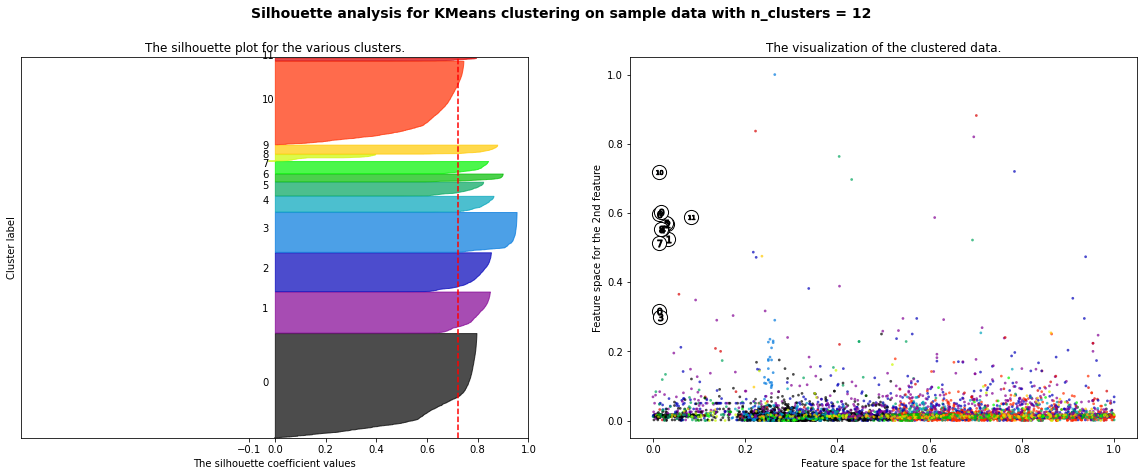

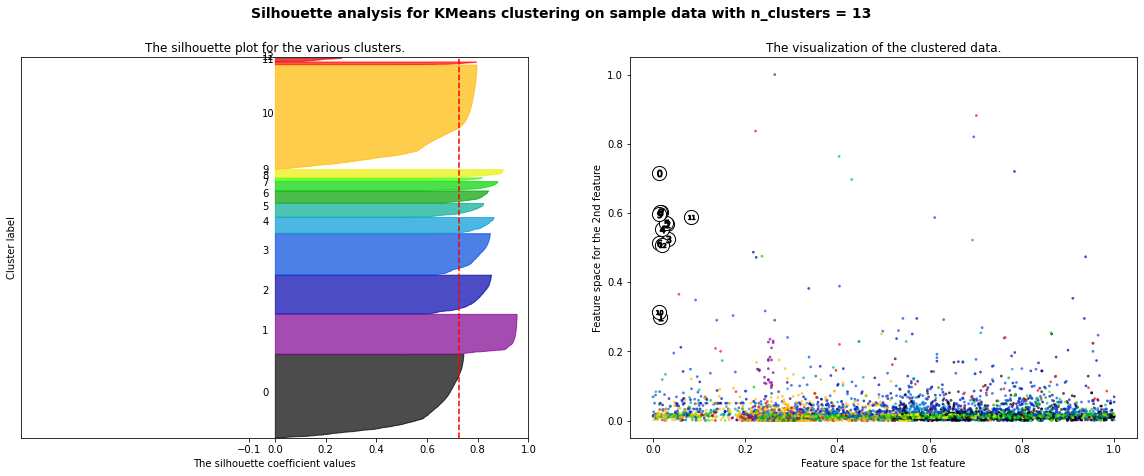

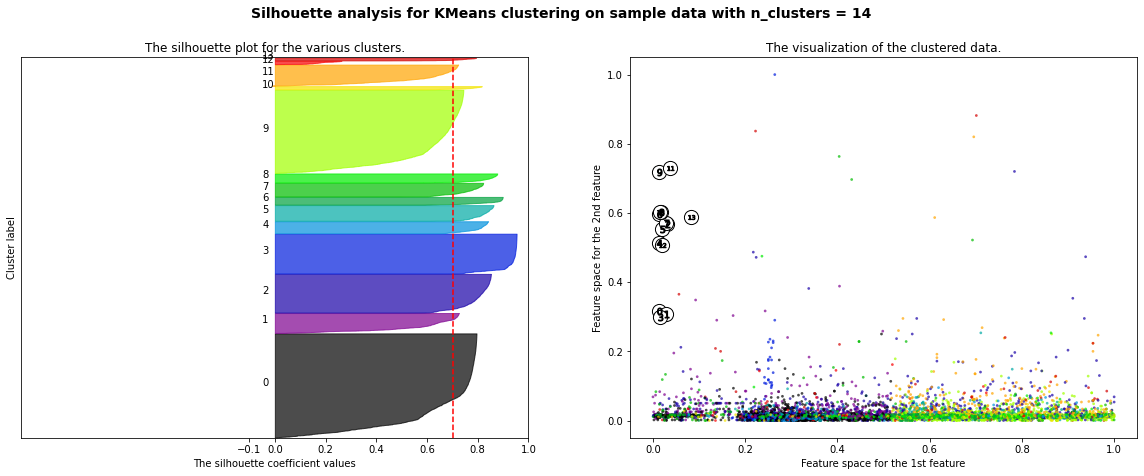

In [179]:
X, y = incident_dummy['Time_in_hours'], incident_dummy['Min_Delay']

for k in range(2,15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 7)
    
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])
    
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(incident_dummy)
    cluster_labels = clusterer.predict(incident_dummy)
    
    silhouette_avg = silhouette_score(incident_dummy, cluster_labels)
    print(
        "For k =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(incident_dummy, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(
        incident_dummy['Time_in_hours'], incident_dummy['Min_Delay'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()
    